In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os
import sys

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate, pokie_test

# Linear Regression – Posterior Inference and Pokie Evaluation

We consider a linear regression setup where we aim to infer the posterior distribution over weights $\boldsymbol{\theta} = [m, b]^\top$ of the linear model:

$$
y = mx + b + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

---

## 1. Likelihood

Given $x_i \in \mathbb{R}$ and $y_i \in \mathbb{R}$, the model is:

$$
y_i \sim \mathcal{N}(x_i^\top \boldsymbol{\theta}, \sigma^2)
$$

where $x_i = [x_i, 1]$ is the augmented input including bias, and $\sigma^2$ is the observation noise variance.

---

## 2. Prior

We place a Gaussian prior on the weights:

$$
\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\mu}_0, \Sigma_0)
$$

This leads to a conjugate posterior.

---

## 3. Posterior

The exact posterior is Gaussian:

$$
\Sigma_{\text{post}} = \left( \Sigma_0^{-1} + A^\top \Sigma_n^{-1} A \right)^{-1}
$$

$$
\boldsymbol{\mu}_{\text{post}} = \Sigma_{\text{post}} \left( A^\top \Sigma_n^{-1} \mathbf{y} + \Sigma_0^{-1} \boldsymbol{\mu}_0 \right)
$$

---

## 4. Posterior Sampling

We sample:

$$
\boldsymbol{\theta}^{(i)} \sim \mathcal{N}(\boldsymbol{\mu}_{\text{post}}, \Sigma_{\text{post}} + \epsilon I)
$$

We evaluate Pokie for each model, comparing posterior calibration across noise levels.

In [4]:
# -------------------------------
# 0. CONFIGURATION
# -------------------------------
num_gt        = 1000               # Number of ground‑truth parameter draws
num_samples   = 1000               # Posterior samples per GT
n             = 100               # Observations per GT
true_sigma    = 1.0               # Observation noise σ
prior_mu      = np.zeros(2)       # Prior mean vector [m0, b0]
prior_Sigma   = np.eye(2) * 1.0   # Prior covariance (τ² I)
noise_levels  = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
num_noise     = len(noise_levels)
curr_num_runs = 100

In [5]:
# -------------------------------
# 1. Storage
# -------------------------------
# ground_truths: shape (num_gt, 2) for [m*, b*]
# ground_truths = np.random.uniform(-5, 5, size=(num_gt, 2))
# m_stars       = np.random.uniform(-1,  1, size=num_gt)
# b_stars       = np.random.uniform(-5,  5, size=num_gt)
m_stars       = np.random.normal(loc=0.0, scale=0.5, size=num_gt)  # e.g., mean=0, std=0.5
b_stars       = np.random.normal(loc=0.0, scale=2.0, size=num_gt)  # e.g., mean=0, std=2.0
ground_truths = np.stack([m_stars, b_stars], axis=1)  # shape (num_gt, 2)

# posteriors: shape (num_noise, num_gt, num_samples, 2)
posteriors = np.zeros((num_noise, num_gt, num_samples, 2))

In [6]:
# -------------------------------
# 2. Posterior Sampling Loop
# -------------------------------
mu_post_array    = np.zeros((num_gt, 2))    # one (2,) mean for each gt_idx
sigma_post_array = np.zeros((num_gt, 2, 2)) # one (2×2) cov  for each gt_idx

for gt_idx in tqdm(range(num_gt), desc="Sampling Linear-Regression Posteriors"):
    m_star, b_star = ground_truths[gt_idx]
    # Generate data
    x = np.random.uniform(-1, 1, size=n)
    y = m_star * x + b_star \
        + np.random.normal(0, true_sigma, size=n)
    # Build design
    A = np.stack([x, np.ones(n)], axis=1)  # shape (n,2)
    
    # Precompute posterior natural parameters
    Sigma_n_inv = np.eye(n) / (true_sigma**2)
    Precision_post = np.linalg.inv(prior_Sigma) + A.T @ Sigma_n_inv @ A
    Sigma_post     = np.linalg.inv(Precision_post)
    mu_post        = Sigma_post @ (A.T @ Sigma_n_inv @ y + np.linalg.inv(prior_Sigma) @ prior_mu)
    # Store posterior mean and covariance
    mu_post_array[gt_idx]    = mu_post
    sigma_post_array[gt_idx] = Sigma_post
    
    # Draw posterior samples, with optional bias inflation
    for nl_idx, scale in enumerate(noise_levels):
        # simulate mis‑calibration by shifting the posterior mean
        delta = np.sqrt(scale) * np.array([1.0, 1.0])  # same shift for both m, b
        biased_mean = mu_post + delta
        # sample from N(biased_mean, Sigma_post)
        posteriors[nl_idx, gt_idx] = np.random.multivariate_normal(
            biased_mean, Sigma_post, size=num_samples
        )

Sampling Linear-Regression Posteriors: 100%|██████████| 1000/1000 [00:00<00:00, 1532.39it/s]


Note that this is different from the main Linear Regression setup. This is Z score normalization for the other metrics (Euclidean is very flexible)

In [7]:
# Allocate
gt_whitened        = np.zeros_like(ground_truths)   # (num_gt,2)
posterior_whitened = np.zeros_like(posteriors)      # (num_noise, num_gt, num_samples, 2)

for gt_idx in range(num_gt):
    mu_post    = mu_post_array[gt_idx]    # now shape (2,)
    Sigma_post = sigma_post_array[gt_idx] # now shape (2,2)

    # 1) Compute W = Σ_post^{-1/2} via Cholesky
    L = np.linalg.cholesky(Sigma_post)  # (2×2)
    W = np.linalg.inv(L)                # so that W @ W.T = Σ_post^{-1}

    # 2) Whiten GT
    centered_gt          = ground_truths[gt_idx] - mu_post    # (2,)
    gt_whitened[gt_idx]  = W @ centered_gt                   # (2,)

    # 3) Whiten each posterior draw
    for nl in range(num_noise):
        draws                = posteriors[nl, gt_idx]        # (num_samples,2)
        centered_draws       = draws - mu_post[None, :]      # (num_samples,2)
        posterior_whitened[nl, gt_idx] = centered_draws @ W.T

In [8]:
print('GT Whitened Shape:', gt_whitened.shape)

print('Posterior Whitened Shape:', posterior_whitened.shape)

GT Whitened Shape: (1000, 2)
Posterior Whitened Shape: (6, 1000, 1000, 2)


In [15]:
list_of_distance_metrics = ['canberra', 'braycurtis', 'seuclidean', 'euclidean', 'cosine', 'correlation', 'cityblock', 'chebyshev']
list_of_distance_metrics = []

# Assume you have a function pokie(gt_norm, posterior_norm, num_runs)
# that returns (raw_probs, calibrated_probs, n_over_N_vals).
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
posterior_norm   = torch.tensor(posterior_whitened, dtype=torch.float32, device=device)
gt_norm = torch.tensor(gt_whitened,   dtype=torch.float32, device=device)

Using device: mps


In [16]:
# Define a text file to save the results
results_file = f"Pokie_Result_Curr_Num_Runs_{curr_num_runs}.txt"

Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 157.28it/s]


Distance Metric: euclidean
Noise Levels: [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
Raw Pokie: [0.19305643 0.19251248 0.16506656 0.15351625 0.14883125 0.14701709]
Calibrated Pokie: [0.661639   0.6597748  0.56571275 0.5261278  0.51007134 0.503854  ]


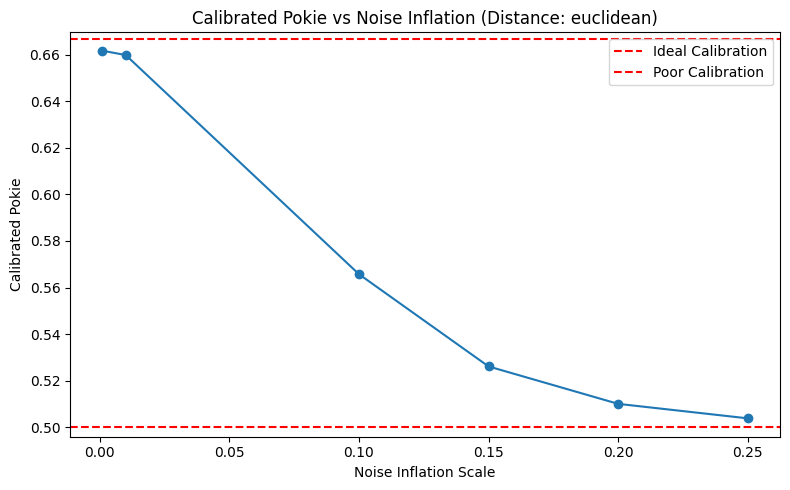

In [20]:
# -------------------------------
# 4. Pokie Evaluation
# -------------------------------
# Open the file in write mode
with open(results_file, "a") as f:
    for distance_metric in list_of_distance_metrics:
        try:
            results, calibrated, n_over_N_vals = pokie_test(
                gt_norm, posterior_norm, num_runs=curr_num_runs, distance_metric=distance_metric
            )
        except Exception as e:
            print(f"Error with distance metric '{distance_metric}': {e}")
            continue

        # Convert results, calibrated, n_over_N_vals back to numpy arrays
        results = results.cpu().numpy()
        calibrated = calibrated.cpu().numpy()
        n_over_N_vals = n_over_N_vals.cpu().numpy()
        print(f"Distance Metric: {distance_metric}")
        print("Noise Levels:", noise_levels)
        print("Raw Pokie:", results)
        print("Calibrated Pokie:", calibrated)

        # Write the results as follows --> Distance Metric | Calibrated Pokie
        for noise_level, cal_pokie in zip(noise_levels, calibrated):
            f.write(f"\n{distance_metric} | {noise_level} | {cal_pokie}\n")

        # -------------------------------
        # 5. Plotting
        # -------------------------------
        plt.figure(figsize=(8,5))
        plt.plot(noise_levels, calibrated, marker='o')
        plt.xlabel('Noise Inflation Scale')
        plt.ylabel('Calibrated Pokie')
        plt.title('Calibrated Pokie vs Noise Inflation (Distance: {})'.format(distance_metric))
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='r', linestyle='--', label='Poor Calibration')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_Distance_{distance_metric}_Curr_Num_Runs_{curr_num_runs}.pdf')
        plt.show()

{'canberra': {0.001: 0.6245549917221069, 0.01: 0.6053299307823181, 0.1: 0.5480979681015015, 0.15: 0.5493230223655701, 0.2: 0.5322329998016357, 0.25: 0.5191090106964111}, 'braycurtis': {0.001: 0.6645969748497009, 0.01: 0.6038740277290344, 0.1: 0.5096150040626526, 0.15: 0.5381479263305664, 0.2: 0.5071009993553162, 0.25: 0.4894009828567505}, 'seuclidean': {0.001: 0.6149049401283264, 0.01: 0.6017850637435913, 0.1: 0.6114299297332764, 0.15: 0.5973359942436218, 0.2: 0.5667939186096191, 0.25: 0.5500909686088562}, 'euclidean': {0.001: 0.6703528761863708, 0.01: 0.6638379693031311, 0.1: 0.5625699758529663, 0.15: 0.5297159552574158, 0.2: 0.533381998538971, 0.25: 0.4884929955005646}, 'cosine': {0.001: 0.6518959999084473, 0.01: 0.5940079689025879, 0.1: 0.5234389901161194, 0.15: 0.5003439784049988, 0.2: 0.49511799216270447, 0.25: 0.49933600425720215}, 'correlation': {0.001: 0.4998609721660614, 0.01: 0.48083996772766113, 0.1: 0.33455100655555725, 0.15: 0.3008739948272705, 0.2: 0.24896200001239777, 0.

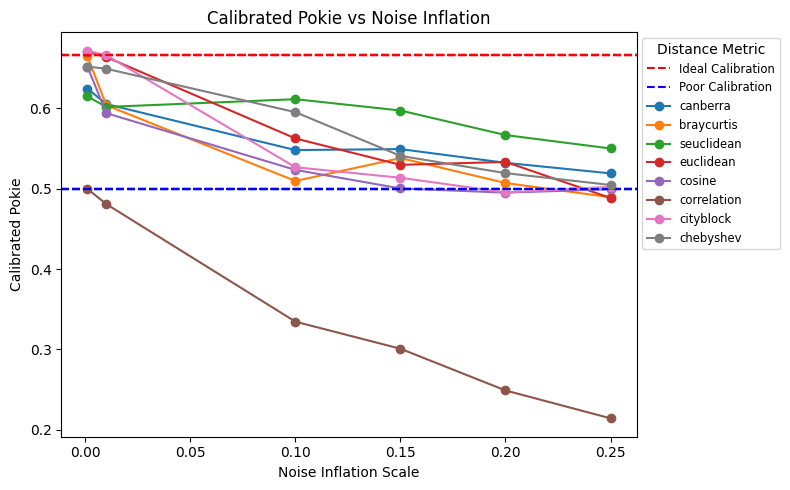

In [21]:
# Load in the data for all the distance metrics
data = {}
results_file = '/Users/sammysharief/Downloads/Pokie/notebook/Distance_Exp/Pokie_Result_Curr_Num_Runs_1.txt'
# Read the results file and store the data
with open(results_file, "r") as f:
    for line in f:
        if line.strip():  # Skip empty lines
            parts = line.strip().split('|')
            if len(parts) == 3:
                distance_metric = parts[0].strip()
                noise_level = float(parts[1].strip())
                calibrated_pokie = float(parts[2].strip())
                
                if distance_metric not in data:
                    data[distance_metric] = {}
                data[distance_metric][noise_level] = calibrated_pokie

print(data)
print(data.keys())
plt.figure(figsize=(8, 5))
# Plot the data for each key in data
for distance_metric, noise_data in data.items():
    noise_levels = sorted(noise_data.keys())
    calibrated_values = [noise_data[nl] for nl in noise_levels]
    
    if distance_metric == 'canberra':
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='b', linestyle='--', label='Poor Calibration')
    else:
        plt.axhline(y=2/3, color='r', linestyle='--')
        plt.axhline(y=1/2, color='b', linestyle='--')
        
    plt.plot(noise_levels, calibrated_values, marker='o', label=distance_metric)
    plt.xlabel('Noise Inflation Scale')
    plt.ylabel('Calibrated Pokie')
    plt.title(f'Calibrated Pokie vs Noise Inflation')
    
 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Distance Metric')

plt.tight_layout()
plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_Different_Distance_Metrics_Curr_Num_Runs_1.pdf')
plt.show()

{'canberra': {0.001: 0.611178457736969, 0.01: 0.6039093732833862, 0.1: 0.5510572195053101, 0.15: 0.5410346388816833, 0.2: 0.5323744416236877, 0.25: 0.5273932218551636}, 'braycurtis': {0.001: 0.6601478457450867, 0.01: 0.5945842266082764, 0.1: 0.5189582109451294, 0.15: 0.5134397745132446, 0.2: 0.5117024779319763, 0.25: 0.5109343528747559}, 'seuclidean': {0.001: 0.6037793159484863, 0.01: 0.6041310429573059, 0.1: 0.6145279407501221, 0.15: 0.5890545845031738, 0.2: 0.5630818605422974, 0.25: 0.5437853932380676}, 'euclidean': {0.001: 0.6616389751434326, 0.01: 0.6597747802734375, 0.1: 0.5657127499580383, 0.15: 0.526127815246582, 0.2: 0.510071337223053, 0.25: 0.503853976726532}, 'cosine': {0.001: 0.6528684496879578, 0.01: 0.5897863507270813, 0.1: 0.5116851329803467, 0.15: 0.5068422555923462, 0.2: 0.5063590407371521, 0.25: 0.5054296255111694}, 'correlation': {0.001: 0.49790096282958984, 0.01: 0.47901004552841187, 0.1: 0.3376530110836029, 0.15: 0.2873243987560272, 0.2: 0.24873510003089905, 0.25: 0

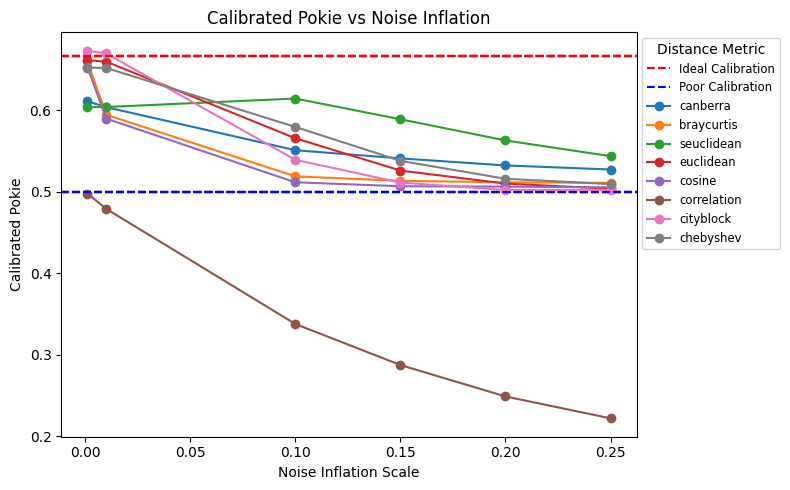

In [22]:
# Load in the data for all the distance metrics
data = {}
results_file = '/Users/sammysharief/Downloads/Pokie/notebook/Distance_Exp/Pokie_Result_Curr_Num_Runs_100.txt'
# Read the results file and store the data
with open(results_file, "r") as f:
    for line in f:
        if line.strip():  # Skip empty lines
            parts = line.strip().split('|')
            if len(parts) == 3:
                distance_metric = parts[0].strip()
                noise_level = float(parts[1].strip())
                calibrated_pokie = float(parts[2].strip())
                
                if distance_metric not in data:
                    data[distance_metric] = {}
                data[distance_metric][noise_level] = calibrated_pokie

print(data)
print(data.keys())
plt.figure(figsize=(8, 5))
# Plot the data for each key in data
for distance_metric, noise_data in data.items():
    noise_levels = sorted(noise_data.keys())
    calibrated_values = [noise_data[nl] for nl in noise_levels]

    if distance_metric == 'canberra':
        plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
        plt.axhline(y=1/2, color='b', linestyle='--', label='Poor Calibration')
    else:
        plt.axhline(y=2/3, color='r', linestyle='--')
        plt.axhline(y=1/2, color='b', linestyle='--')
    
    plt.plot(noise_levels, calibrated_values, marker='o', label=distance_metric)
    plt.xlabel('Noise Inflation Scale')
    plt.ylabel('Calibrated Pokie')
    plt.title(f'Calibrated Pokie vs Noise Inflation')
    
 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Distance Metric')

plt.tight_layout()
plt.savefig(f'{project_root}/Plots/Different_Distance_Metrics/Pokie_Different_Distance_Metrics_Curr_Num_Runs_100.pdf')
plt.show()